In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Infected Dataset - using Greedy Approach

In [ ]:
infected_dataframe = pd.read_csv('Infected_Data.csv')
infected_dataframe

,ID,Fever,Cough,Breathing Issues,Infected
0,1,N,N,N,N
1,2,Y,Y,Y,Y
2,3,Y,Y,N,N
3,4,Y,N,Y,Y
4,5,Y,Y,Y,Y
5,6,N,Y,N,N
6,7,Y,N,Y,Y
7,8,Y,N,Y,Y
8,9,N,Y,Y,Y
9,10,Y,Y,N,Y


In [ ]:
infected_dataframe = infected_dataframe.drop(columns=['ID'])
infected_dataframe

,Fever,Cough,Breathing Issues,Infected
0,N,N,N,N
1,Y,Y,Y,Y
2,Y,Y,N,N
3,Y,N,Y,Y
4,Y,Y,Y,Y
5,N,Y,N,N
6,Y,N,Y,Y
7,Y,N,Y,Y
8,N,Y,Y,Y
9,Y,Y,N,Y


In [ ]:
#Calculating Entropy
def calculate_entropy(data_column):
    unique_values, value_counts = np.unique(data_column, return_counts=True)
    probabilities = value_counts / value_counts.sum()
    # Added a small value (epsilon) to prevent log(0) which is undefined
    entropy_value = -sum(probabilities * np.log2(probabilities + 1e-9))
    return entropy_value

In [ ]:
#Calculating Information Gain
def calculate_information_gain(dataframe, attribute, target_name):
    total_entropy = calculate_entropy(dataframe[target_name])
    # We calculate the weighted average of entropy for the attribute
    unique_values, value_counts = np.unique(dataframe[attribute], return_counts=True)
    weighted_entropy = np.sum([
        (value_counts[i] / np.sum(value_counts)) * calculate_entropy(dataframe.where(dataframe[attribute] == unique_values[i]).dropna()[target_name])
        for i in range(len(unique_values))
    ])

    information_gain_value = total_entropy - weighted_entropy
    return information_gain_value

# Base case 1: If all target values are the same, return that value.
# Base case 2: If there are no more features to split on, return the most common target value.

In [ ]:
#Recursive Algorithm
def build_decision_tree(dataframe, available_features, target_name):
    if dataframe.empty:
        return "No data for this path"

    # Base case 1
    if dataframe[target_name].nunique() == 1:
        return dataframe[target_name].iloc[0]

    # Base case 2
    if len(available_features) == 0:
        return dataframe[target_name].mode().iloc[0]

    information_gains = [calculate_information_gain(dataframe, feature, target_name) for feature in available_features]
    best_attribute = available_features[np.argmax(information_gains)]

    decision_tree = {best_attribute: {}}  #We are creating decision tree

    # Recursively build the subtrees for each value of the best attribute
    remaining_features = [feature for feature in available_features if feature != best_attribute]
    for value, data_subset in dataframe.groupby(best_attribute, observed=True):
        decision_tree[best_attribute][value] = build_decision_tree(data_subset, remaining_features, target_name)

    return decision_tree

In [ ]:
def display_tree(tree, indentation=""):
    if not isinstance(tree, dict):
        print(indentation + "-> Predict: " + str(tree))
        return
    for attribute, value_branches in tree.items():
        print(indentation + str(attribute) + "?")
        for value, subtree in value_branches.items():
            print(indentation + f"|-- If value is {value}:")
            display_tree(subtree, indentation + "  ")

In [ ]:
features_list = infected_dataframe.columns[:-1].tolist()
target_column_name = infected_dataframe.columns[-1]
scratched_built_tree = build_decision_tree(infected_dataframe, features_list, target_column_name)

In [ ]:
display_tree(scratched_built_tree)

Breathing Issues?
|-- If value is N:
  Fever?
  |-- If value is N:
    -> Predict: N
  |-- If value is Y:
    Cough?
    |-- If value is Y:
      -> Predict: N
|-- If value is Y:
  Fever?
  |-- If value is N:
    Cough?
    |-- If value is Y:
      -> Predict: Y
  |-- If value is Y:
    -> Predict: Y


#Infected Dataset - using Scikit Learn

In [ ]:
encoded_infected_dataframe = infected_dataframe.copy()


In [ ]:
for column_name in encoded_infected_dataframe.columns:
    encoded_infected_dataframe[column_name] = encoded_infected_dataframe[column_name].map({'Y': 1, 'N': 0})

In [ ]:
features = encoded_infected_dataframe.drop('Infected', axis=1)
target = encoded_infected_dataframe['Infected']
infected_feature_names = features.columns.tolist()


In [ ]:
training_features, testing_features, training_target, testing_target = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
infected_decision_tree = DecisionTreeClassifier(criterion='entropy',random_state=42)
infected_decision_tree.fit(training_features, training_target)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
infected_predictions = infected_decision_tree.predict(testing_features)
infected_accuracy = accuracy_score(testing_target, infected_predictions)
infected_confusion_matrix = confusion_matrix(testing_target, infected_predictions)

In [ ]:
print(f"Accuracy: {infected_accuracy * 100:.2f}%")
print("Confusion Matrix:\n", infected_confusion_matrix)

Accuracy: 33.33%
Confusion Matrix:
 [[1 0]
 [2 0]]


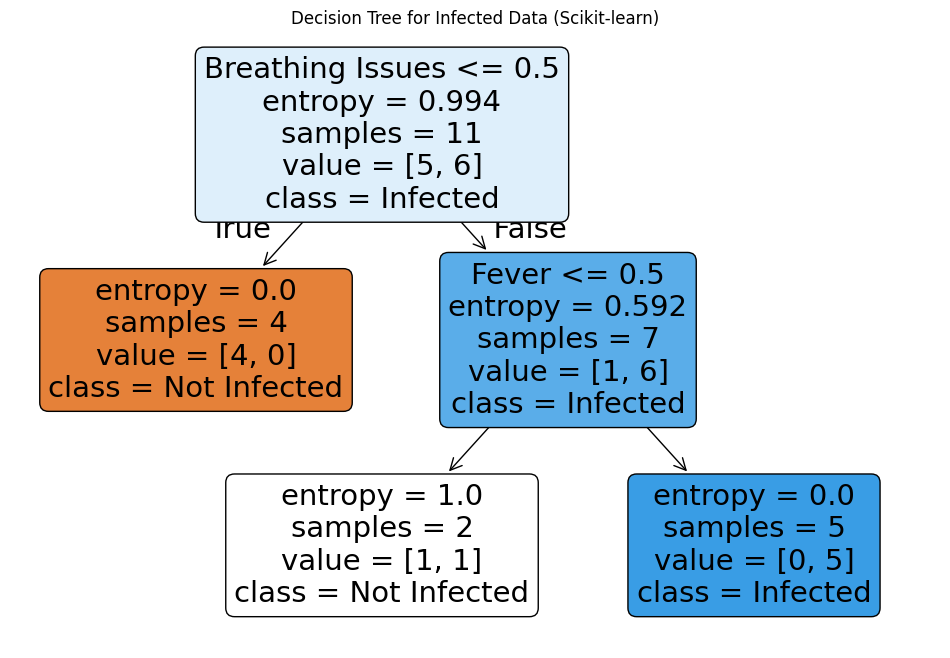

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(infected_decision_tree, feature_names=infected_feature_names, class_names=['Not Infected', 'Infected'], filled=True, rounded=True)
plt.title("Decision Tree for Infected Data (Scikit-learn)")
plt.show()

In [ ]:
infected_decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth = 1, random_state=42)
infected_decision_tree.fit(training_features, training_target)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42)

In [ ]:
infected_predictions = infected_decision_tree.predict(testing_features)
infected_accuracy = accuracy_score(testing_target, infected_predictions)
infected_confusion_matrix = confusion_matrix(testing_target, infected_predictions)

In [ ]:
print(f"Accuracy: {infected_accuracy * 100:.2f}%")
print("Confusion Matrix:\n", infected_confusion_matrix)

Accuracy: 66.67%
Confusion Matrix:
 [[1 0]
 [1 1]]


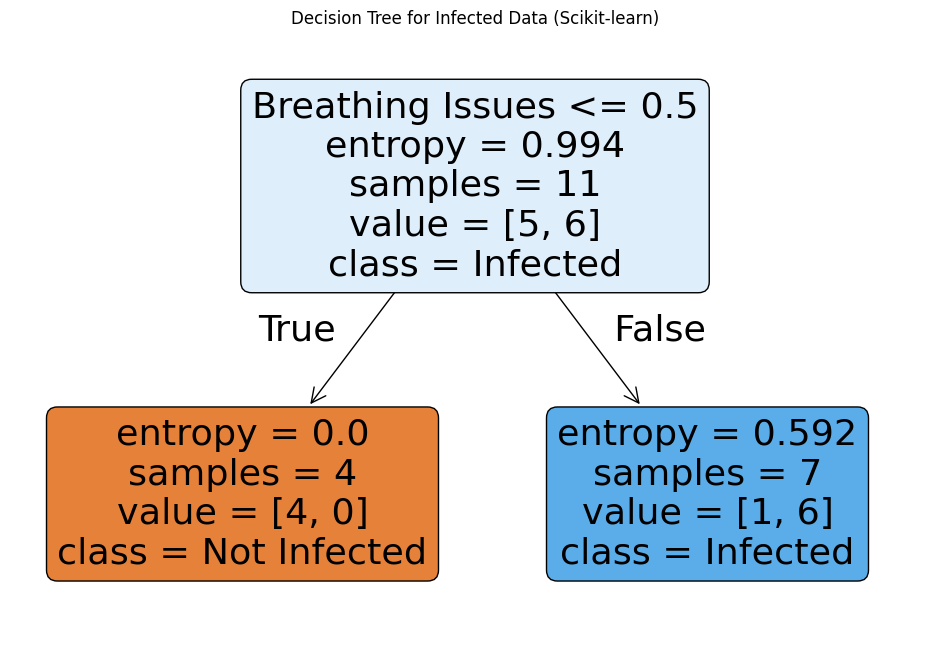

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(infected_decision_tree, feature_names=infected_feature_names, class_names=['Not Infected', 'Infected'], filled=True, rounded=True)
plt.title("Decision Tree for Infected Data (Scikit-learn)")
plt.show()

Analyzing the Effect of max_depth on Accuracy
Calculating accuracy for different max_depth values...
Accuracy for max_depth = 1: 66.67%
Accuracy for max_depth = 2: 33.33%
Accuracy for max_depth = 3: 33.33%


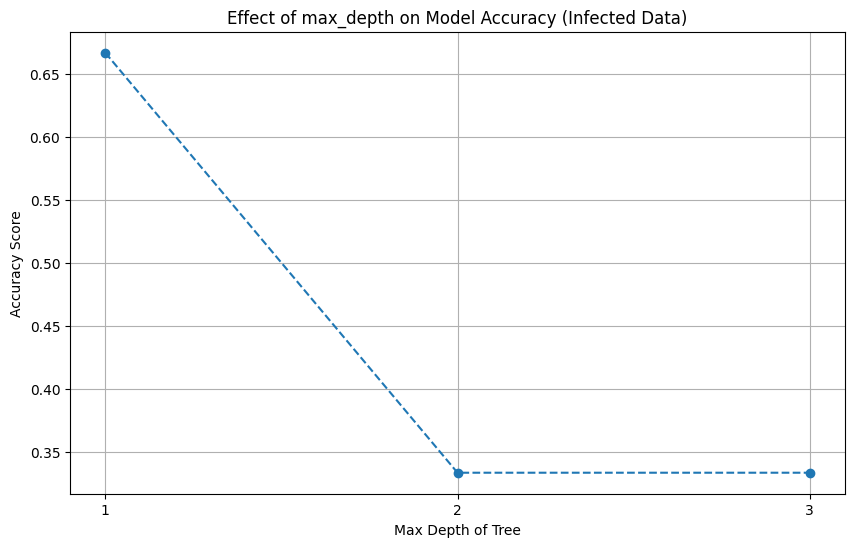

In [ ]:
print("Analyzing the Effect of max_depth on Accuracy")

max_depth_values = range(1, len(features.columns) + 1)
accuracy_results = []

print("Calculating accuracy for different max_depth values...")
for depth in max_depth_values:
    temp_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    temp_tree_model.fit(training_features, training_target)

    predictions_for_depth = temp_tree_model.predict(testing_features)
    current_accuracy = accuracy_score(testing_target, predictions_for_depth)
    accuracy_results.append(current_accuracy)
    print(f"Accuracy for max_depth = {depth}: {current_accuracy * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, accuracy_results, marker='o', linestyle='--')
plt.title('Effect of max_depth on Model Accuracy (Infected Data)')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy Score')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

#Iris Dataset - using Greedy Approach

In [ ]:
from sklearn.datasets import load_iris
iris_dataset_for_scratch = load_iris()


In [ ]:
iris_dataframe = pd.DataFrame(data=np.c_[iris_dataset_for_scratch['data'], iris_dataset_for_scratch['target']],
                               columns=list(iris_dataset_for_scratch['feature_names']) + ['target'])


In [ ]:
discretized_iris_df = iris_dataframe.copy()
for feature_name in iris_dataset_for_scratch.feature_names:
    discretized_iris_df[feature_name] = pd.cut(discretized_iris_df[feature_name],
                                               bins=3,
                                               labels=['low', 'medium', 'high'])

In [ ]:
discretized_iris_df['target'] = discretized_iris_df['target'].astype(int).astype(str)

In [ ]:
iris_features_list = discretized_iris_df.columns[:-1].tolist()
iris_target_name = 'target'

iris_scratched_built_tree = build_decision_tree(discretized_iris_df, iris_features_list, iris_target_name)

print("Decision Tree for Iris Dataset from Scratch (using discretized features):")
display_tree(iris_scratched_built_tree)

Decision Tree for Iris Dataset from Scratch (using discretized features):
petal width (cm)?
|-- If value is low:
  -> Predict: 0
|-- If value is medium:
  petal length (cm)?
  |-- If value is medium:
    sepal length (cm)?
    |-- If value is low:
      sepal width (cm)?
      |-- If value is low:
        -> Predict: 1
      |-- If value is medium:
        -> Predict: 1
    |-- If value is medium:
      -> Predict: 1
    |-- If value is high:
      -> Predict: 1
  |-- If value is high:
    sepal length (cm)?
    |-- If value is medium:
      sepal width (cm)?
      |-- If value is low:
        -> Predict: 2
      |-- If value is medium:
        -> Predict: 1
    |-- If value is high:
      -> Predict: 2
|-- If value is high:
  petal length (cm)?
  |-- If value is medium:
    sepal width (cm)?
    |-- If value is low:
      -> Predict: 2
    |-- If value is medium:
      sepal length (cm)?
      |-- If value is medium:
        -> Predict: 2
  |-- If value is high:
    -> Predict: 2


#Iris Dataset - using Scikit Learn

In [ ]:
iris_dataset = load_iris()
iris_features = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
iris_target = pd.Series(iris_dataset.target)

In [ ]:
iris_training_features, iris_testing_features, iris_training_target, iris_testing_target = train_test_split(iris_features, iris_target, test_size=0.2, random_state=42)

In [ ]:
iris_decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
iris_decision_tree.fit(iris_training_features, iris_training_target)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
iris_predictions = iris_decision_tree.predict(iris_testing_features)
iris_accuracy = accuracy_score(iris_testing_target, iris_predictions)
iris_confusion_matrix = confusion_matrix(iris_testing_target, iris_predictions)

print(f"Iris Dataset Accuracy: {iris_accuracy * 100:.2f}%")
print("Iris Dataset Confusion Matrix:\n", iris_confusion_matrix)

Iris Dataset Accuracy: 100.00%
Iris Dataset Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


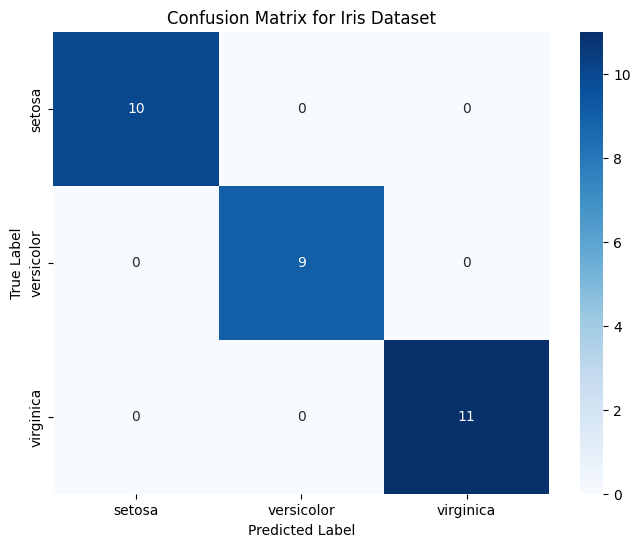

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(iris_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris_dataset.target_names, yticklabels=iris_dataset.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Iris Dataset')
plt.show()

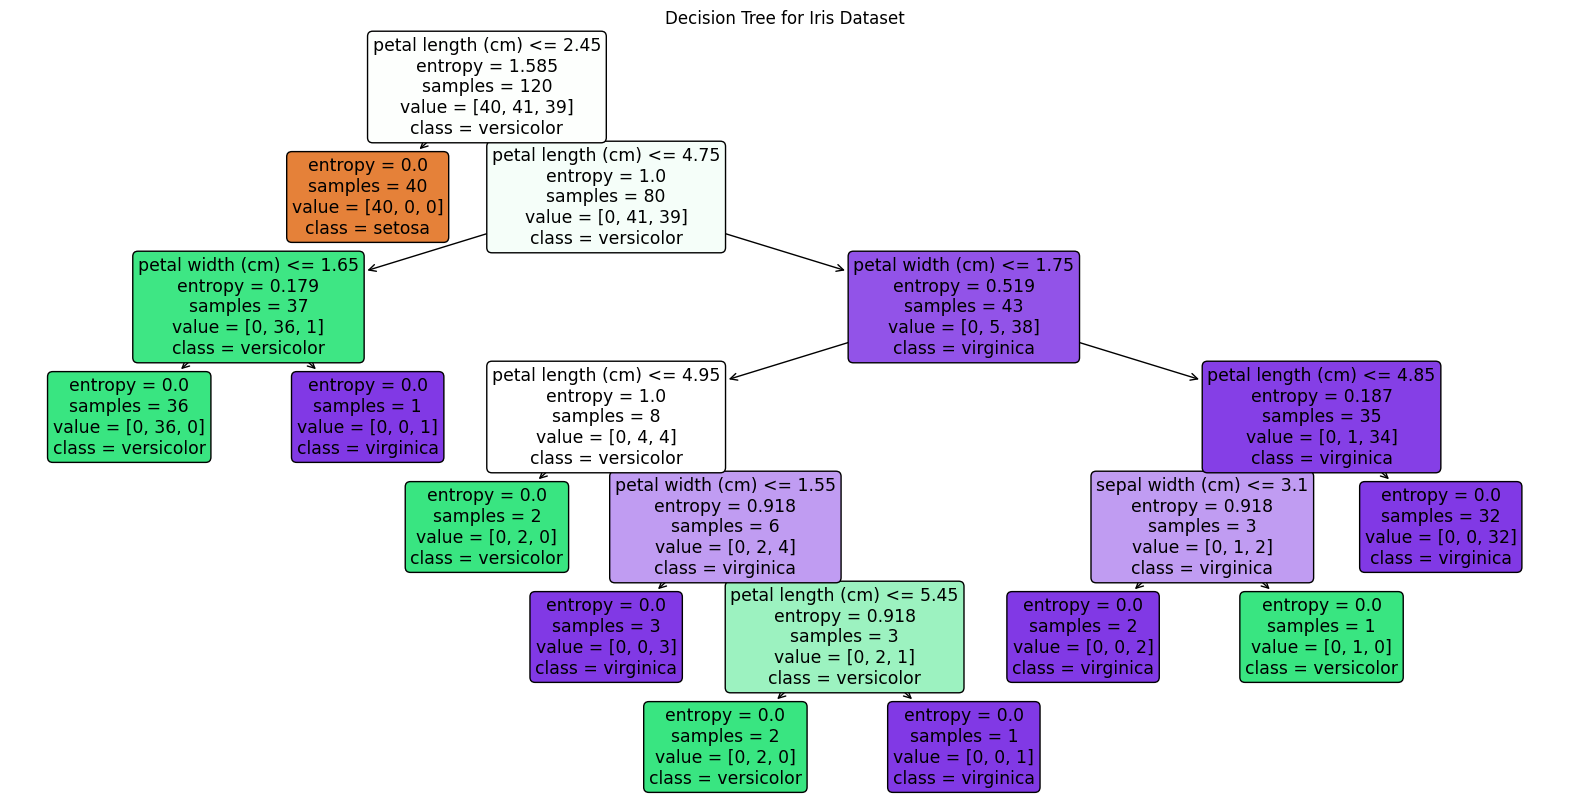

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(iris_decision_tree, feature_names=iris_dataset.feature_names, class_names=list(iris_dataset.target_names), filled=True, rounded=True)
plt.title("Decision Tree for Iris Dataset")
plt.show()

In [ ]:
iris_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth = 2,random_state=42)
iris_decision_tree.fit(iris_training_features, iris_training_target)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

In [ ]:
iris_predictions = iris_decision_tree.predict(iris_testing_features)
iris_accuracy = accuracy_score(iris_testing_target, iris_predictions)
iris_confusion_matrix = confusion_matrix(iris_testing_target, iris_predictions)

print(f"Iris Dataset Accuracy: {iris_accuracy * 100:.2f}%")
print("Iris Dataset Confusion Matrix:\n", iris_confusion_matrix)

Iris Dataset Accuracy: 96.67%
Iris Dataset Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]


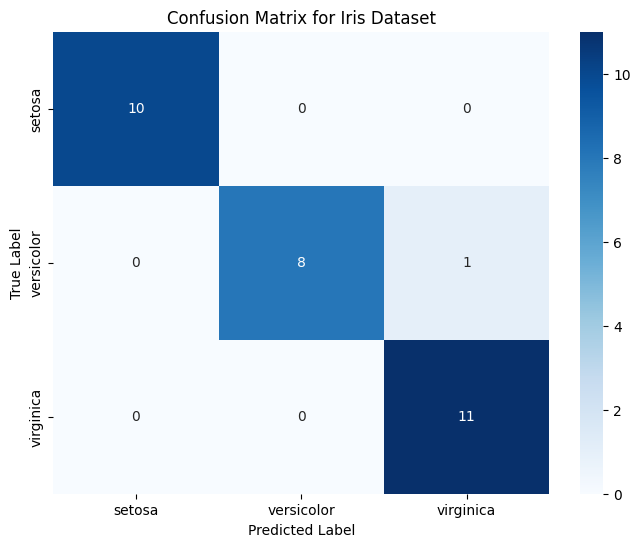

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(iris_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris_dataset.target_names, yticklabels=iris_dataset.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Iris Dataset')
plt.show()

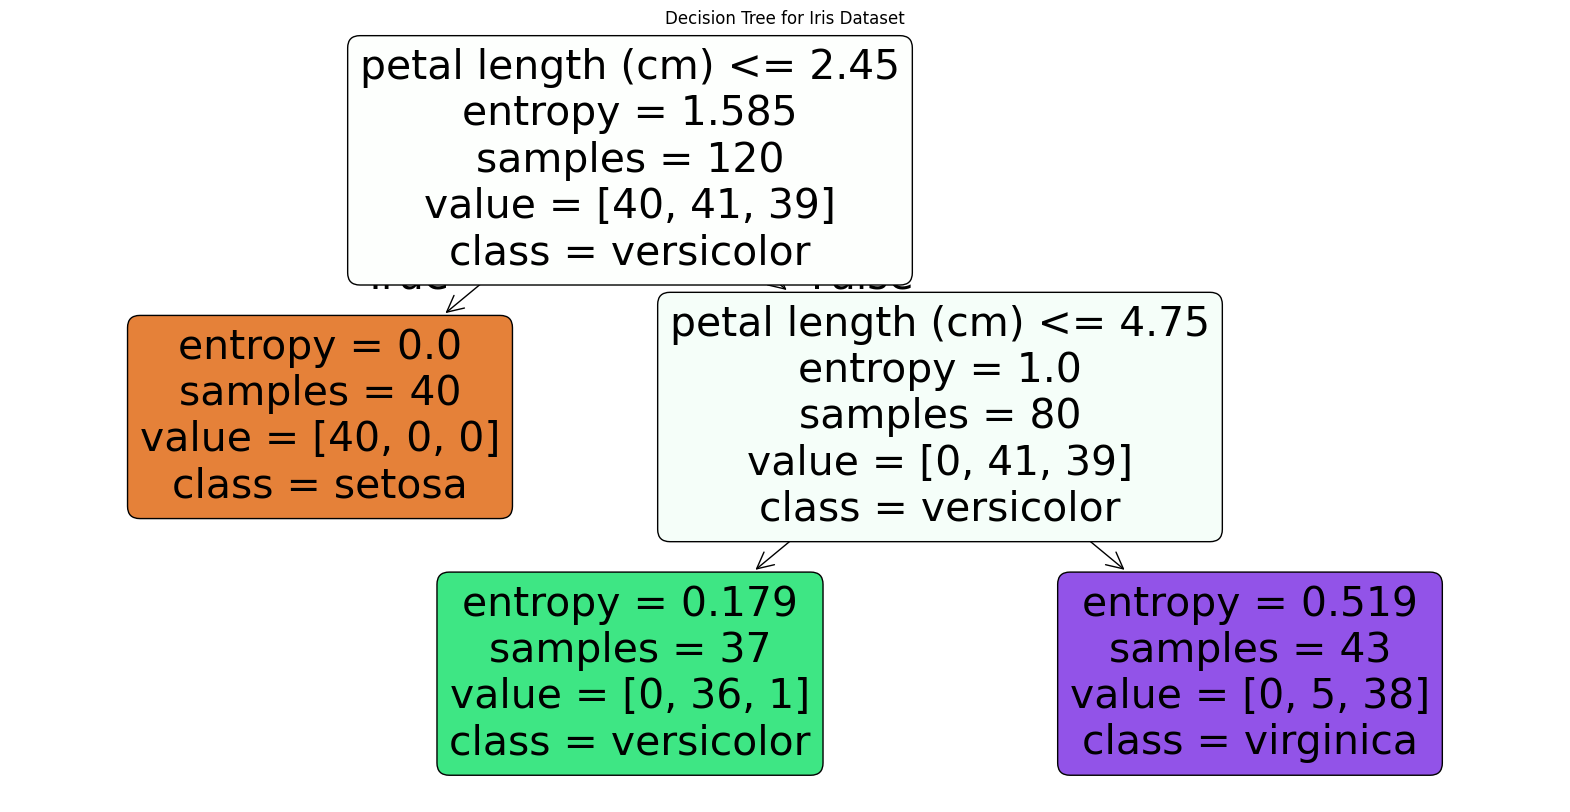

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(iris_decision_tree, feature_names=iris_dataset.feature_names, class_names=list(iris_dataset.target_names), filled=True, rounded=True)
plt.title("Decision Tree for Iris Dataset")
plt.show()

In [ ]:
print("\nAnalyzing the Effect of max_depth on Accuracy (Iris Dataset)")

iris_max_depth_values = range(1, 11)
iris_accuracy_results = []

print("Calculating accuracy for different max_depth values...")
for depth in iris_max_depth_values:
    iris_temp_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    iris_temp_tree_model.fit(iris_training_features, iris_training_target)

    iris_predictions_for_depth = iris_temp_tree_model.predict(iris_testing_features)
    iris_current_accuracy = accuracy_score(iris_testing_target, iris_predictions_for_depth)
    iris_accuracy_results.append(iris_current_accuracy)
    print(f"Accuracy for max_depth = {depth}: {iris_current_accuracy * 100:.2f}%")


Analyzing the Effect of max_depth on Accuracy (Iris Dataset)
Calculating accuracy for different max_depth values...
Accuracy for max_depth = 1: 63.33%
Accuracy for max_depth = 2: 96.67%
Accuracy for max_depth = 3: 100.00%
Accuracy for max_depth = 4: 100.00%
Accuracy for max_depth = 5: 100.00%
Accuracy for max_depth = 6: 100.00%
Accuracy for max_depth = 7: 100.00%
Accuracy for max_depth = 8: 100.00%
Accuracy for max_depth = 9: 100.00%
Accuracy for max_depth = 10: 100.00%


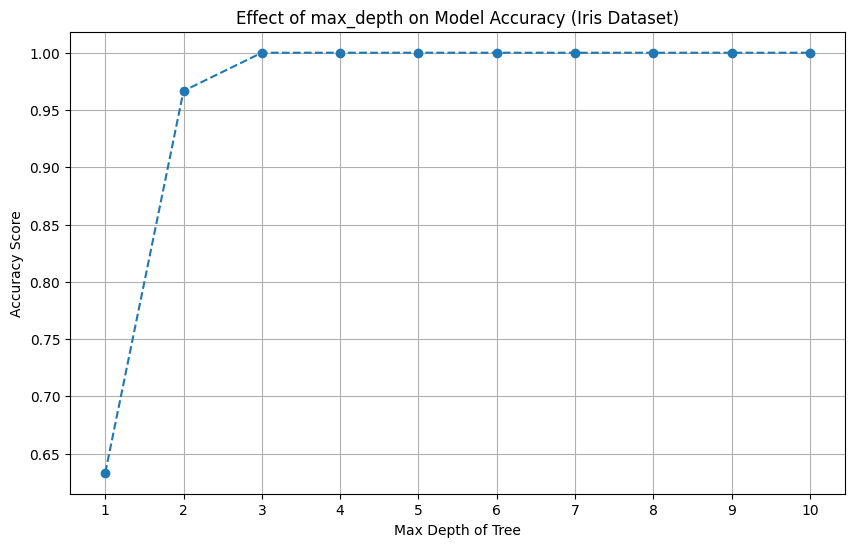

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(iris_max_depth_values, iris_accuracy_results, marker='o', linestyle='--')
plt.title('Effect of max_depth on Model Accuracy (Iris Dataset)')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy Score')
plt.xticks(iris_max_depth_values)
plt.grid(True)
plt.show()